In [9]:
import matplotlib.pyplot as plt
import numpy as np

A=np.load('day1.npy')        # contact patterns day 1
B=np.load('day2.npy')        # contact patterns day 2
day1=np.load('times1.npy')   # time series vector day 1
day2=np.load('times2.npy')   # time series vector day 2
no=np.load('numbers.npy')    # number of individuals
metadata=np.loadtxt('metadata_primaryschool.txt',delimiter='\t',dtype='str')

#  Transimission function -----------------------------------------------#
def transmit(A_at_t,s,ias,isy,home):
    for ij in np.argwhere(A_at_t!=0):
        i=ij[0]
        j=ij[1]
	# conditions
        infectious1= (ias[i]!=0 or isy[i]!=0)and home[i]<=0 and homecl[i]<=0 
        sus1= (s[i]==1 and homecl[i]<=0 )
        infectious2=(ias[j]!=0 or isy[j]!=0)and home[j]<=0 and homecl[j]<=0 
        sus2= (s[j]==1 and homecl[j]<=0)
        if (infectious1 and sus2):                
            rtemp=np.random.random()
            if isy[i]!=0:
                bina=rtemp > (1-beta)**A_at_t[i,j]
            else:
                bina=rtemp > (1-beta/2.)**A_at_t[i,j]
            if bina==1:
               # print 'pupil w/ ID', j, 'got exposed'
                ex[j]=1*(np.random.normal()*mu*0.1 + mu)
                arrival[j]=tt
                s[j]=0   #now at exposed 
        if (infectious2 and sus1):
            rtemp=np.random.random() # random number
            if isy[j]!=0:
                bina=rtemp > (1-beta)**A_at_t[i,j]
            else:
                bina=rtemp > (1-beta/2.)**A_at_t[i,j]
            if bina==1:
               # print 'pupil w/ ID', j, 'got exposed'
                ex[i]=1*(np.random.normal()*mu*0.1 + mu)
                arrival[i]=tt
                #print (tt/72.)
                s[i]=0   #now at exposed
#  End of day removal of symtomatic function-----------------------------------#    
def eod(grades,tt,isy,home,rec):            
    new=np.setdiff1d(np.nonzero(isy)[0],np.nonzero(home)[0])
    home[new]=isy[new]

#  Time passage function ------------------------------------------------------#        
def timepass(grades,gradesPrev,tt,ias,rec,ex,isy,home,s):

    # infection of susceptibles by community
    comminfec(s,ex)
    
    # those infected: time passes
    ias[np.nonzero(ias)[0]]-=1.00000001
    isy[np.nonzero(isy)[0]]-=1.00000001
    # those at home: time passes
    home[np.nonzero(home)[0]]-= 1.00000001
    homecl[np.nonzero(homecl)[0]]-= 1.00000001
    
    # after recovery period they recover:
    rec[ias<0]=1
    rec[isy<0]=1

    # save this recovery to the prevalence time-series
    if any(isy<0):
        for i in np.where(isy<0)[0]:
            try:
                grade=metadata[i, 1].astype('S1').astype('i1')  -1  
            except:
                grade=5 #teacher
            gradesPrev[grade,tt:slots,batchno]=gradesPrev[grade,tt,batchno]-1        
    if any(ias<0): 
        for i in np.where(ias<0)[0]:
            try:
                grade=metadata[i, 1].astype('S1').astype('i1')  -1
            except:
                grade=5  #teacher
            gradesPrev[grade,tt:slots,batchno]=gradesPrev[grade,tt,batchno]-1
    ias[ias<0]=0
    isy[isy<0]=0    

    #those exposed: pass time
    ex[np.nonzero(ex)[0]]-=1.00000001

    # after exposure: disease develops: either with or without symptoms
    for i in np.argwhere(ex<0):
        ran=np.random.random()
        ias[i]=(ran<pa)* (np.random.normal()*gamma*0.1 + gamma)
        isy[i]=(ran>pa)*(np.random.normal()*gamma*0.1 + gamma)
        ex[i]=0
        #note: matrix A and ias, isy are already sorted
        # again, save this to prevalence time-series:
        try:
            grade=metadata[i, 1].astype('S1').astype('i1')[0]  -1
            grades[grade,tt:slots]=grades[grade,tt]+1
            gradesPrev[grade,tt:slots,batchno]=gradesPrev[grade,tt,batchno]+1
        except:
            # teacher
            gradesPrev[5,tt:slots,batchno]=gradesPrev[5,tt,batchno]+1   
#  Targeted grade closure intervention function ------------------------------------#
#      ...is only executed if threshhold is exceeded        
def targetedClosure(tt,gradesPrev,ias,isy,home,homecl,s,dates):       
    grademax=np.argmax(gradesPrev[:,tt,batchno]) 
    cond1=(grademax!=5) and previousgrade[grademax]==0
    if gradesPrev[grademax,tt,batchno] > threshhold and cond1:
        dates.append(tt/72.0*60)
        previousgrade[grademax]=1
        for i in range(243):
            try:
                grade=metadata[i, 1].astype('S1').astype('i1') -1
            except:
                pass  ## teachers still go to school
            if grade==grademax:
                #s[i]=0; ias[i]=0; isy[i]=0; ex[i]=0
                homecl[i]=clPeriod  

#  Save info to vectors ------------------------------------------------------------#    
def svinfo(t,s_time, ias_time, isy_time, rec_time,ex_time, s,ias,isy,rec,ex):
	## svinfo saves the current states 
    s_time[t]=(sum(s!=0))
    ias_time[t]=(sum(ias!=0))
    isy_time[t]=(sum(isy!=0))
    rec_time[t]=(sum(rec!=0))
    ex_time[t]=(sum(ex!=0))

#  Community infection function -----------------------------------------------------#       
def comminfec(s,ex):
    new= np.random.rand(len(np.argwhere(s==1))) < beta_spon  # times dt
    ex[np.argwhere(s==1)[new]]=1*(np.random.normal()*gamma*0.1 + gamma)    
    s[np.argwhere(s==1)[new]]=0

In [10]:
maxbatch=1 # how many simulations should be carried out

# specify parameters
maxdays=50;  noplot=0
threshhold=3; clPeriod=24*3*4*60;
slots=int(24*3*maxdays*60 +25*3*np.ceil(maxdays/7.)*60)
gamma=60*24*3*4.
mu=60*24*3*2.
beta=20*3.5* 10**-4 ; beta_spon=20*2.8* 10**-9
pa=1/3
# Init batch info aggregating vectors
epd=() # saves the simulations with AR>10%
gradesPrev=np.zeros((6,slots,maxbatch),dtype=np.int32) # saves the prevalences
total_cases_AR = 0
for batchno in range(maxbatch):
    tt=0
    # Init vectors for new simulation:
    s_time= np.zeros(slots,dtype=np.int32)
    ias_time= np.zeros(slots,dtype=np.int32)
    isy_time= np.zeros(slots,dtype=np.int32)
    rec_time= np.zeros(slots,dtype=np.int32)
    ex_time= np.zeros(slots,dtype=np.int32)
    home=np.zeros((no),dtype=np.float64)
    homecl=np.zeros((no),dtype=np.float64)
    s=np.ones((no),dtype=np.int32)
    ias=np.zeros((no),dtype=np.float64)
    isy=np.zeros((no),dtype=np.float64)
    ex=np.zeros((no),dtype=np.float64)
    rec=np.zeros((no),dtype=np.int32)
    previousgrade= np.zeros(5,dtype=np.int32)
    arrival=np.zeros(242)        # saves arrival dates of infection
    grades=np.zeros((6,slots),dtype=np.int32)        
    dates=[]		     # saves dates of grade closure

    # Initially infect  one individual --------------------------------\
    tinder=np.random.randint(no, size=1)				   #|
    isy[tinder]=1*(np.random.normal()*gamma*0.1 + gamma)		  
    s[tinder]=0   # this individual is removed from S class            #|
    # save this initially infected to gradesPrev time-series          
    try:								   #|
        grade=metadata[tinder, 1].astype('S1').astype('i1')  -1        
    except:								   #|	
        grade=5 #teacher       
    grades[grade,tt:slots]=grades[grade,tt]+1
    gradesPrev[grade,tt:slots,batchno]=gradesPrev[grade,tt,batchno]+1  #|
    # -----------------------------------------------------------------/

    while (tt<maxdays*24*3*60): #main time-loop
        if not any(gradesPrev[:,tt,batchno]) and all(ex==0):
            #no one sick and no one exposed, end simulation
            break
        else:
            if np.mod(tt+24*3*2*60,24*3*7*60)==0:    #weekend 
                for t in range (72*60+72*60):
                    timepass(grades,gradesPrev,tt,ias,rec,ex,isy,home,s)
                    svinfo(tt,s_time, ias_time, isy_time, rec_time,ex_time, s,ias,isy,rec,ex)
                    tt+=1
                eod(grades,tt,isy,home,rec)
            for t in day1:
                transmit(A[:,:,t],s, ias,isy,home)
                timepass(grades,gradesPrev,tt,ias,rec,ex,isy,home,s)
                # targetedClosure(tt,gradesPrev,ias,isy,home,homecl,s,dates)
                svinfo(tt,s_time, ias_time, isy_time, rec_time,ex_time, s,ias,isy,rec,ex)
                tt+=1                     
            for t in range (72*60-A.shape[2]): #A has 25 20min slots
                timepass(grades,gradesPrev,tt,ias,rec,ex,isy,home,s)
                svinfo(tt,s_time, ias_time, isy_time, rec_time,ex_time, s,ias,isy,rec,ex)
                tt+=1
            eod(grades,tt,isy,home,rec)
            if np.mod(tt+24*3*4*60,24*3*7*60)==0:    #wednesday
                for t in range (72*60):
                    timepass(grades,gradesPrev,tt,ias,rec,ex,isy,home,s)
                    svinfo(tt,s_time, ias_time, isy_time, rec_time,ex_time, s,ias,isy,rec,ex)
                    tt+=1
                eod(grades,tt,isy,home,rec)
            if np.mod(tt+24*3*2*60,24*3*7*60)==0:    #weekend 
                for t in range (72*60+72*60): 
                    timepass(grades,gradesPrev,tt,ias,rec,ex,isy,home,s)
                    svinfo(tt,s_time, ias_time, isy_time, rec_time,ex_time, s,ias,isy,rec,ex)
                    tt+=1 
                eod(grades,tt,isy,home,rec)
            for t in day2:
                transmit(B[:,:,t],s, ias,isy,home)
                timepass(grades,gradesPrev,tt,ias,rec,ex,isy,home,s)
                #  targetedClosure(tt,gradesPrev,ias,isy,home,homecl,s,dates)
                svinfo(tt,s_time, ias_time, isy_time, rec_time,ex_time, s,ias,isy,rec,ex)
                tt+=1       
            for t in range (72*60-B.shape[2]): #B has 25 20min slots
                timepass(grades,gradesPrev,tt,ias,rec,ex,isy,home,s)
                svinfo(tt,s_time, ias_time, isy_time, rec_time,ex_time, s,ias,isy,rec,ex)
                tt+=1
            eod(grades,tt,isy,home,rec)
            if np.mod(tt+24*3*4*60,24*3*7*60)==0:    #wednesday
                for t in range (72*60):
                    timepass(grades,gradesPrev,tt,ias,rec,ex,isy,home,s)
                    svinfo(tt,s_time, ias_time, isy_time, rec_time,ex_time, s,ias,isy,rec,ex)
                    tt+=1
                eod(grades,tt,isy,home,rec)
    total_cases = np.max(np.sum(grades, axis=0), axis=0)
    if total_cases > 242/10:
        print('warning')
        epd=epd+(batchno,)
        total_cases_AR += total_cases
    # graphics follow


warning


In [8]:
A.shape

(243, 243, 1555)

In [11]:
epd

(0,)

In [136]:
len(epd)

48

In [15]:
high_attack_stat = gradesPrev[:,:,epd]
high_attack_stat = np.sum(high_attack_stat, axis=0)
high_attack_stat_ave = np.median(high_attack_stat, axis=1)
cases_num_day = high_attack_stat_ave[::72*60]

<Axes: >

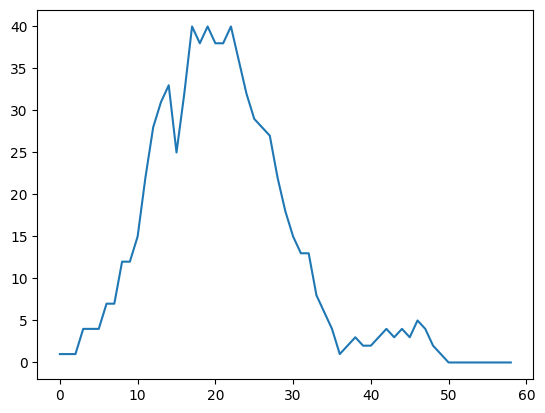

In [16]:
import pandas as pd
cases_num_day_series = pd.Series(cases_num_day)
cases_num_day_series.plot()